In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import collections

In [2]:
# preprocessing
data = pd.read_csv('reviews.csv')
data = data[['cleaned_review', 'sentiments']].reset_index(drop=True)
data = data.rename(columns={'cleaned_review': 'text', 'sentiments': 'review_score'})
data['text'] = data['text'].astype(str)
data['text'] = data['text'].apply(lambda x: x.strip())
data = data[(data['text'] != '') & (data['text'] != ' ')]
data = data[data['text'].apply(len) > 1]
data.replace(['negative','neutral','positive'],[0.0, 1.0, 2.0],inplace=True)
data.head(10)

,text,review_score
0,i wish would have gotten one earlier love it a...,2.0
1,i ve learned this lesson again open the packag...,1.0
2,it is so slow and lags find better option,1.0
3,roller ball stopped working within months of m...,1.0
4,i like the color and size but it few days out ...,1.0
5,overall love this mouse the size weight clicki...,2.0
6,it stopped working,1.0
7,my son uses school issued chromebook for schoo...,2.0
8,loved this cute little mouse but it broke afte...,0.0
9,should ve spent the money to get quality produ...,0.0


2.0    9503
1.0    6283
0.0    1534
Name: review_score, dtype: int64


<AxesSubplot: title={'center': 'sentiment score distribution'}>

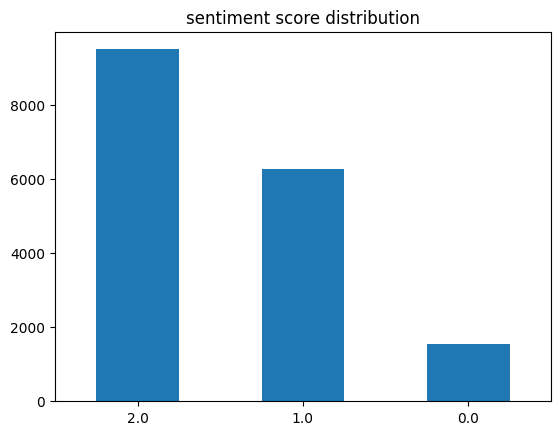

In [3]:
data = data.sample(frac=1).reset_index(drop=True) # shuffle the data
print(data["review_score"].value_counts())
data['review_score'].value_counts().plot(kind='bar', title='sentiment score distribution', rot=0)

In [4]:
X = data['text'].values
X = [review.split(' ') for review in X]
Y = data['review_score'].values.astype(float)
X[:3]

[['use', 'it', 'for', 'streaming', 'love', 'it'],
 ['the',
  'mouse',
  'came',
  'as',
  'described',
  'with',
  'the',
  'option',
  'chose',
  'however',
  'after',
  'letting',
  'it',
  'charge',
  'for',
  'the',
  'recommended',
  'time',
  'before',
  'use',
  'it',
  'would',
  'not',
  'connect',
  'to',
  'my',
  'computer',
  'turned',
  'it',
  'off',
  'and',
  'then',
  'back',
  'on',
  'and',
  'it',
  'worked',
  'for',
  'about',
  'minutes',
  'within',
  'that',
  'minutes',
  'only',
  'showed',
  'one',
  'color',
  'the',
  'whole',
  'time',
  'it',
  'never',
  'worked',
  'again',
  'afterwards',
  'just',
  'went',
  'and',
  'bought',
  'mouse',
  'from',
  'walmart',
  'and',
  'it',
  'works',
  'like',
  'perfect',
  'even',
  'more',
  'sturdier',
  'than',
  'this',
  'one',
  'don',
  'waste',
  'your',
  'money',
  'on',
  'this'],
 ['we',
  'used',
  'this',
  'on',
  'family',
  'campout',
  'and',
  'had',
  'great',
  'results',
  'the',
  'volu

In [5]:
# build mappings
words = [word for review in X for word in review]
most_common = collections.Counter(words).most_common(round(len(set(words))*0.95)) # take 95% of the most common words
most_common_words = [word for word, _ in most_common]
str_to_inx = {str:inx for inx, str in enumerate(most_common_words)}
inx_to_str = {inx:str for inx, str in enumerate(most_common_words)}
len(str_to_inx)

9114

In [6]:
# build dataset
X_set = []
for review in X:
    encoded_review = []
    for word in review:
        if word in most_common_words:
            encoded_review.append(str_to_inx[word])
    X_set.append(encoded_review)

max_len = len(max(X_set, key=len))
for review in X_set: 
    review.extend([0]*(max_len-len(review))) # pad with zeros

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
X_set = torch.tensor(X_set, dtype=torch.long).to(device)
Y_set = torch.tensor(Y, dtype=torch.long).to(device)
X_set.shape, Y_set.shape

(torch.Size([17320, 571]), torch.Size([17320]))

In [9]:
# data set splits 80%, 10%, 10%
train_range = round(len(X_set) * 0.8)
dev_range = (len(X_set) - train_range) // 2

training_set = X_set[:train_range]
dev_set = X_set[train_range:train_range+dev_range]
test_set = X_set[train_range+dev_range:]

y_training_set = Y_set[:train_range]
y_dev_set = Y_set[train_range:train_range+dev_range]
y_test_set = Y_set[train_range+dev_range:]

assert training_set.nelement() + dev_set.nelement() + test_set.nelement() == X_set.nelement(), "Bad split"

In [10]:
n_embd = 32 # dim of the character embedding vector
n_hidden = 64 # the # of neurons in the hidden layer
block_size = X_set.shape[1] # the length of the input vector
vocab_size = len(inx_to_str) # the size of the vocabulary
n_categories = 3 # the number of classes
g = torch.Generator().manual_seed(2147483647)

class MLP(nn.Module):
    def __init__(self, vocab_size, n_embd):
        super().__init__()
        self.linear_tanh_stack = nn.Sequential(
            nn.Embedding(vocab_size, n_embd), nn.Flatten(),
            nn.Linear(block_size * n_embd, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Dropout(p=0.35), nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Dropout(p=0.35), nn.LeakyReLU(),
            nn.Linear(n_hidden, n_hidden, bias=False), nn.BatchNorm1d(n_hidden), nn.Dropout(p=0.35), nn.LeakyReLU(),
            nn.Linear(n_hidden, n_categories), nn.BatchNorm1d(n_categories)
        )

    def forward(self, x):
        logits = self.linear_tanh_stack(x)
        return logits

In [11]:
model = MLP(vocab_size=vocab_size, n_embd=n_embd).to(device)
print(model)

MLP(
  (linear_tanh_stack): Sequential(
    (0): Embedding(9114, 32)
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=18272, out_features=64, bias=False)
    (3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.35, inplace=False)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=64, out_features=64, bias=False)
    (7): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout(p=0.35, inplace=False)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=64, out_features=64, bias=False)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Dropout(p=0.35, inplace=False)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=64, out_features=3, bias=True)
    (15): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [12]:
"Number of parameters: " + str(sum(p.nelement() for p in model.parameters()))

'Number of parameters: 1469833'

In [13]:
@torch.no_grad() # disable gradient tracking
def get_loss(model, data_set):
    # model.eval()
    x, y = {
        'train': (training_set, y_training_set),
        'dev': (dev_set, y_dev_set),
        'test': (test_set, y_test_set)
    }[data_set]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    return loss.item()

In [14]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.0001, momentum=0.9)
steps = 16000
batch_size = 64
model.train()
losses, inxs, dev_loss = [], [], []
for epoch in range(steps):
    inx = torch.randint(0, training_set.shape[0], (batch_size,), generator=g)
    emb = training_set[inx] # grab only those rows from the minibatch 

    optimizer.zero_grad()

    # forward pass
    preds = model(emb)
    loss = loss_function(preds, y_training_set[inx])

    # backward pass
    loss.backward()

    # update the weights
    optimizer.step()

    #stats
    if epoch % 1000 == 0: # print every once in a while
        print(f'{epoch:7d}/{steps:7d}: {loss.item():.4f}')
    if epoch % 50 == 0:
        dev_loss.append(get_loss(model, 'dev'))
        losses.append(loss.item())
        inxs.append(epoch)
   
loss

      0/  16000: 1.3672
   1000/  16000: 1.1453
   2000/  16000: 0.8609
   3000/  16000: 0.6715
   4000/  16000: 0.7672
   5000/  16000: 0.6654
   6000/  16000: 0.6016
   7000/  16000: 0.4535
   8000/  16000: 0.4900
   9000/  16000: 0.4795
  10000/  16000: 0.3635
  11000/  16000: 0.3860
  12000/  16000: 0.4558
  13000/  16000: 0.3898
  14000/  16000: 0.3596
  15000/  16000: 0.4551


tensor(0.4120, device='cuda:0', grad_fn=<NllLossBackward0>)

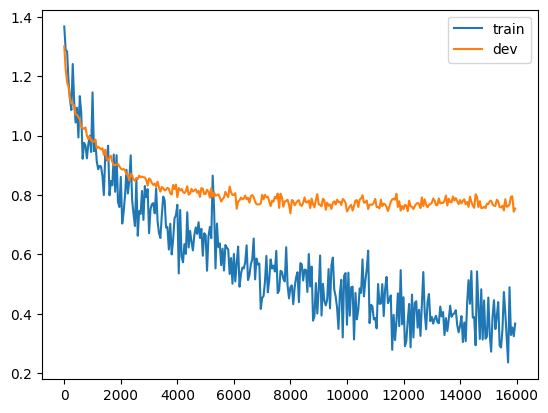

In [15]:
plt.plot(inxs, losses, label='train')
plt.plot(inxs, dev_loss, label='dev')
plt.legend()

In [16]:
print(get_loss(model,'train'))
print(get_loss(model,'dev'))
get_loss(model,'test')

0.3289650082588196
0.7617917060852051


0.7613381743431091

In [17]:
# accuracy on the specified set
@torch.no_grad()
def get_accuracy(model, set, set_labels):
    model.eval()
    correct = 0
    total = set_labels.size(0)

    logits = model(set)
    probs = F.softmax(logits, dim=1)

    predicted = torch.argmax(probs.data, 1)
    print(predicted, set_labels)
    correct = (predicted == set_labels).sum().item()
    print(pd.DataFrame(predicted.cpu().numpy()).value_counts())

    print(f'Accuracy of the network on the {set_labels.size(0)} test reviews: {100 * correct // total} %')
get_accuracy(model, test_set, y_test_set)

tensor([2, 2, 1,  ..., 1, 1, 2], device='cuda:0') tensor([2, 2, 1,  ..., 0, 2, 2], device='cuda:0')
2    925
1    745
0     62
dtype: int64
Accuracy of the network on the 1732 test reviews: 76 %


In [18]:
# sample from the model
sentiment_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
@torch.no_grad()
def sample(model, rev):
    model.eval()
    rev = rev.split(' ')
    x = torch.tensor([str_to_inx[x] for x in rev] + [0]*(X_set.shape[1]-len(rev)), dtype=torch.long).to(device)
    x = x.view(1, -1)
    logits = model(x)
    probs = F.softmax(logits, dim=1)
    # print(probs.data)
    predicted = torch.argmax(probs.data, dim=1)
    return probs, sentiment_map[predicted.item()]

print(sample(model, 'i hate this product'))
print(sample(model, 'i like this product'))
sample(model, 'i love this product')

(tensor([[0.0463, 0.6725, 0.2812]], device='cuda:0'), 'neutral')
(tensor([[0.0305, 0.8348, 0.1347]], device='cuda:0'), 'neutral')


(tensor([[0.0174, 0.0481, 0.9345]], device='cuda:0'), 'positive')